In [1]:
import sys
sys.path.append('/Users/danielhug/neuraldragon/.venv/lib/python3.10/site-packages')
sys.path.append("/Users/danielhug/neuraldragon/gitensor/BabyDragon")

In [2]:
from datasets import load_dataset

/Users/danielhug/neuraldragon/gitensor/BabyDragon/notebooks/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from babydragon.memory.indexes.memory_index import MemoryIndex


In [11]:
dataset_url = "OpenAssistant/oasst1"
dataset = load_dataset(dataset_url)['train']

Found cached dataset parquet (/Users/danielhug/.cache/huggingface/datasets/OpenAssistant___parquet/OpenAssistant--oasst1-2960c57d7e52ab15/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|██████████| 2/2 [00:00<00:00, 182.31it/s]


In [12]:
dataset.column_names

['message_id',
 'parent_id',
 'user_id',
 'created_date',
 'text',
 'role',
 'lang',
 'review_count',
 'review_result',
 'deleted',
 'rank',
 'synthetic',
 'model_name',
 'detoxify',
 'message_tree_id',
 'tree_state',
 'emojis',
 'labels']

In [13]:
dataset[0]

{'message_id': '6ab24d72-0181-4594-a9cd-deaf170242fb',
 'parent_id': None,
 'user_id': 'c3fe8c76-fc30-4fa7-b7f8-c492f5967d18',
 'created_date': '2023-02-05T14:23:50.983374+00:00',
 'text': 'Can you write a short introduction about the relevance of the term "monopsony" in economics? Please use examples related to potential monopsonies in the labour market and cite relevant research.',
 'role': 'prompter',
 'lang': 'en',
 'review_count': 3,
 'review_result': True,
 'deleted': False,
 'rank': None,
 'synthetic': False,
 'model_name': None,
 'detoxify': {'toxicity': 0.00044308538781479,
  'severe_toxicity': 3.252684837207198e-05,
  'obscene': 0.00023475120542570949,
  'identity_attack': 0.0001416115992469713,
  'insult': 0.00039489680784754455,
  'threat': 4.075629112776369e-05,
  'sexual_explicit': 2.712695459194947e-05},
 'message_tree_id': '6ab24d72-0181-4594-a9cd-deaf170242fb',
 'tree_state': 'ready_for_export',
 'emojis': {'name': ['+1', '_skip_reply', '_skip_ranking'],
  'count': [10

In [14]:

#filter by language
dataset = dataset.filter(lambda example: example['lang'] == 'en')

In [15]:
values = dataset.select_columns(['text'])


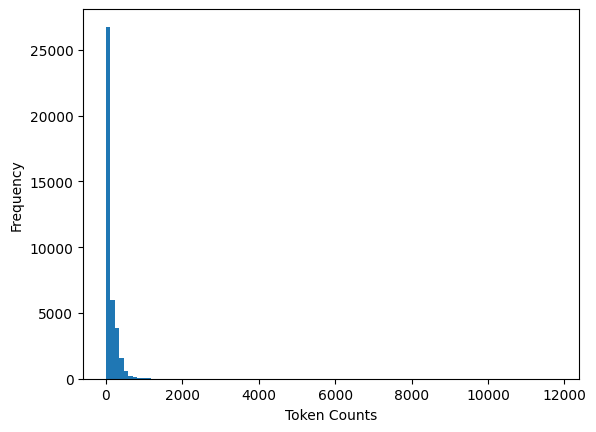

In [33]:
import tiktoken
import matplotlib.pyplot as plt

tokenizer = tiktoken.encoding_for_model("gpt-3.5-turbo")
token_counts = []
filtered_values = []
for val in values:
    tokens = tokenizer.encode(val['text'], disallowed_special=())
    num_tokens = len(tokens)
    if num_tokens < 512:
        filtered_values.append(val['text'])
    token_counts.append(num_tokens)

plt.hist(token_counts, bins=100)
plt.xlabel('Token Counts')
plt.ylabel('Frequency')
plt.show()


In [28]:
max(token_counts)

11794

In [16]:
values[0]['text']

'Can you write a short introduction about the relevance of the term "monopsony" in economics? Please use examples related to potential monopsonies in the labour market and cite relevant research.'

In [30]:
from babydragon.models.embedders.cohere import CohereEmbedder
cohere_embedder = CohereEmbedder()

In [31]:
cohere_embedder.get_embedding_size()

768

In [36]:
import cohere
co = cohere.Client('LeohkffIg5ucAxbMSfiCIhZ0RL9M2uuw0GVb99ZN')
# batch list into lists of 1000 and merge embeddings into a single ist
embedding_set = []
for i in range(0, len(filtered_values), 1000):
    print(i)
    if i + 1000 < len(filtered_values):
        response = co.embed(texts= filtered_values[i:i+1000],model='multilingual-22-12')
    else:
        response = co.embed(texts= filtered_values[i:],model='multilingual-22-12')
    print(len(response.embeddings))
    embeddings = response.embeddings
    embedding_set.extend(embeddings)


0
1000
1000
1000
2000
1000
3000
1000
4000
1000
5000
1000
6000
1000
7000
1000
8000
1000
9000
1000
10000
1000
11000
1000
12000
1000
13000
1000
14000
1000
15000
1000
16000
1000
17000
1000
18000
1000
19000
1000
20000
1000
21000
1000
22000
1000
23000
1000
24000
1000
25000
1000
26000
1000
27000
1000
28000
1000
29000
1000
30000
1000
31000
1000
32000
1000
33000
1000
34000
1000
35000
1000
36000
1000
37000
1000
38000
404


In [39]:
import numpy as np
np.array(embedding_set).shape

(38404, 768)

In [40]:
OA_index = MemoryIndex(values=filtered_values, embeddings=embedding_set, name='OA_cohere_index', embedder=CohereEmbedder)

Creating a new index from a list of embeddings and values
37908  values in the index
37908  embeddings in the index


In [41]:
OA_index.faiss_query("What is the meaning of life?")

(['What is the meaning of life?',
  "What's the meaning of life?",
  'what is the meaning of life?',
  'The meaning of life is a philosophical and existential question that has been debated and explored by scholars, theologians, and thinkers for centuries. There is no single, universally accepted answer to this question, as the meaning of life is subjective and may differ from person to person.\n\nSome people may find meaning in relationships, such as family or romantic relationships, while others may find meaning through their work or career. Others may find meaning in spirituality, religion, or personal growth.\n\nUltimately, the meaning of life may be a personal and individual journey, and each person may need to explore their own beliefs, values, and experiences to determine their own understanding of the meaning of life.',
  'Tell me what is the meaning of life?',
  "The meaning of life is a complex and multi-faceted concept that can vary greatly depending on one's philosophical o

In [16]:
from babydragon.chat.memory_chat import FifoChat


In [18]:
chatbot = FifoChat(model= "command", index_dict = {"OA_cohere_index":OA_index}, name="babyd_chatbot", max_index_memory = 2500, max_output_tokens= 400)

Index is available so using index prompts


In [19]:
chatbot.reply("What is the meaning of life?")

Trying to call Cohere API... using model: command


#### Question: 
 What is the meaning of life?

 #### Anwser: 
 
According to Hinduism, the meaning of life is to realize that one's soul is identical to the supreme soul, that the supreme soul is present in everything and everyone, all life is interconnected and there is oneness in all life.

"\nAccording to Hinduism, the meaning of life is to realize that one's soul is identical to the supreme soul, that the supreme soul is present in everything and everyone, all life is interconnected and there is oneness in all life."